[0.         0.00134424 0.04165989]


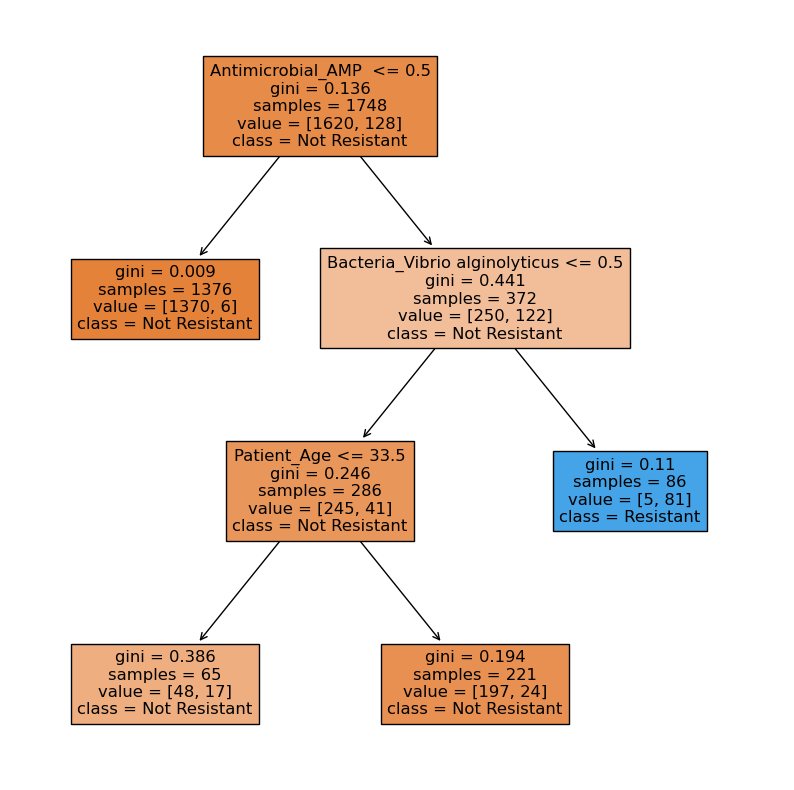

training accuracy = 0.9702517162471396
testing accuracy = 0.9742710120068611
[[549  14]
 [  1  19]]


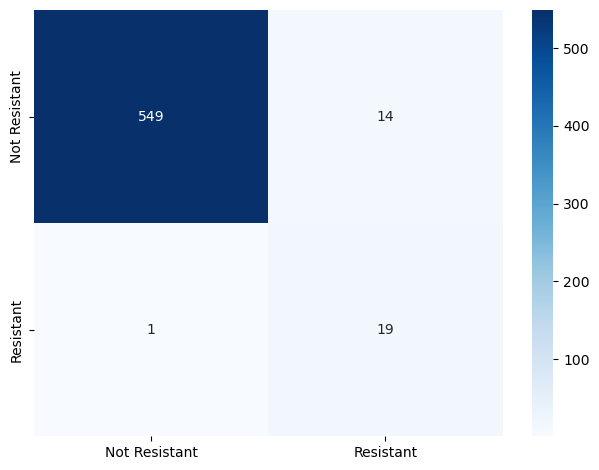

sensitivity= 0.95 specificity= 0.9751332149200711


In [22]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


##########################################
##D-Tree Hyper-parameters
##########################################
min_impurity_thr = 0.001               #Default min_impurity threshold for Dtree (Default is 0.001)
ccp_thr = 0.0001                        #Default ccp_thr threshold for Dtree (Default is 0.0001)
max_depth_thr = 30                     #Default max_depth threshold for Dtree (Default is 15)
min_samples_leaf_thr = 5              #Default min_samples_leaf threshold for Dtree (Default is 30)


def prepare_data(org_df):
    #select target attributes
    org_df = org_df.loc[:,org_df.columns.isin(['MIC_Interpretation', 'Antimicrobial', 'Patient_Age', 'Bacteria'])]

    # Categorical to Numeric
    org_df = pd.get_dummies(org_df, columns=['MIC_Interpretation', 'Antimicrobial', 'Bacteria'], dtype='int')

    # Remove Unused columns
    org_df= org_df.drop(['MIC_Interpretation_intermediate', 'MIC_Interpretation_susceptible'],axis = 1)

    #remove_outliers in Patient_Age
    values = [vl for vl in org_df['Patient_Age'] if not np.isnan(vl)]
    q3, q1 = np.percentile(values, [75, 25])
    fence = 1.5 * (q3 - q1)
    upper_band = q3 + fence
    lower_band = q1 - fence
    org_df.loc[(org_df['Patient_Age'] < lower_band) | (org_df['Patient_Age'] > upper_band), 'Patient_Age'] = None

    #impute dataset
    imputer = IterativeImputer(max_iter=10, random_state=0)
    imputed_dataset = imputer.fit_transform(org_df)
    imputed_dataframe = pd.DataFrame(imputed_dataset, columns=org_df.columns)
    return imputed_dataframe


#Input Dateset
org_df = pd.read_csv("/Users/zhangxijing/MasterNEU/INFO6105DataScienceEngineeringMethodsandTools/Dataset/DS_Dataset.csv")
clean_df = prepare_data(org_df)

#Define features to predict Resistance label
label_df = clean_df.loc[:,clean_df.columns == 'MIC_Interpretation_resistant']
feat_df = clean_df.loc[:,clean_df.columns != 'MIC_Interpretation_resistant']

#Seperate test and train data
train_feat,test_feat,train_label,test_label = train_test_split(feat_df,label_df,test_size=0.25)

#Create a model using Hyper-parameters
treemodel= tree.DecisionTreeClassifier(criterion="gini",
                                       min_impurity_decrease=min_impurity_thr,
                                       max_depth=max_depth_thr,
                                       min_samples_leaf=min_samples_leaf_thr,
                                       ccp_alpha=ccp_thr)
#Train the model
treemodel.fit(train_feat, train_label)

#pruning specification
path = treemodel.cost_complexity_pruning_path(train_feat, train_label)
ccp_alphas =  path['ccp_alphas']
print(ccp_alphas)

#Visualize the model
plt.figure(figsize=(10,10))
tree.plot_tree(treemodel,feature_names=train_feat.columns.tolist(),class_names=['Not Resistant','Resistant'],filled=True)
plt.show()

train_pred_label = treemodel.predict(train_feat)
training_accuracy=accuracy_score(train_pred_label,train_label)
print ('training accuracy =',training_accuracy )

test_pred_label = treemodel.predict(test_feat)
testing_accuracy=accuracy_score(test_pred_label,test_label)
print ('testing accuracy =',testing_accuracy )

#Calculate confusion matrix
cf=confusion_matrix(test_pred_label,test_label)
print(cf)

#Visualize confusion matrix
sns.heatmap(cf,annot=True,yticklabels=['Not Resistant','Resistant']
               ,xticklabels=['Not Resistant','Resistant'],cmap='Blues', fmt='g')
plt.tight_layout()
plt.show()

#Calculate sensitivity and specificity
sensitivity = cf[1, 1] / (cf[1, 0] + cf[1, 1])
specificity = cf[0, 0] / (cf[0, 0] + cf[0, 1])
print ('sensitivity=',sensitivity, 'specificity=',specificity )